In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import utils.plot as pu

In [4]:
# Solve the constraint by finding roots of the polynomial
# P(x) = 1 - x + l1*x^5 + l2*x^5*(1 - l1*(1 - kappa)*x^4)^5 == 0

def get_roots(l1, l2, kappa):      

    # safeguard
    if l1 == 0 and l2 == 0:
        root = 1.0
        condition_val = 1 - l1 * (root**4) 
        if condition_val > 0:
            return [0.0]
        
    coeffs = np.zeros(26)
    C = l1 * (1 - kappa)
    
    coeffs[0] = -l2 * (C**5)     
    coeffs[4] = l2 * 5 * (C**4)  
    coeffs[8] = -l2 * 10 * (C**3)
    coeffs[12] = l2 * 10 * (C**2)
    coeffs[16] = -l2 * 5 * C     
    coeffs[20] = l1 + l2         
    coeffs[24] = -1              
    coeffs[25] = 1

    roots = np.roots(coeffs)

    # filter out complex roots and those that do not satisfy the condition
    # 1 - l1 * (x**4) > 0 (the conformal factor must be positive and non-increasing)
    valid_roots = []
    for complex_root in roots:
        if np.isclose(np.imag(complex_root), 0):
            real_root = np.real(complex_root)
            if real_root > 1e-9:
                condition_val = 1 - l1 * (real_root**4)
                if condition_val > 1e-9:
                    valid_roots.append(real_root)

    if not valid_roots:
        return []

    results = []
    for root in valid_roots:
        term1 = l1 / kappa
        base_val = 1 + (root**4) * (kappa - 1) * l1
        term2_base_pow5 = base_val**5
        term2 = l2 * (root**5) * term2_base_pow5
        result = 2 * (term1 + term2)
        results.append(result)
 
    return sorted(list(set(results)))

In [5]:
def interactive_graph(grain):
    def update_plot(k1, k2, rho):
        alphas_for_plot = []
        m_adm_values = []
        alpha_max = 5.0

        num_steps = int(round(5.0 / grain)) + 1
        alpha_values = np.linspace(0.00001, alpha_max, num_steps)

        for alpha in alpha_values:
            current_k1 =  k1
            current_k2 =  alpha * k2
            current_rho = rho

            if alpha == 0.0:
                if abs(rho) > 1e-9:
                    m_results = [0.0]
                else:
                    m_results = []
            else:
                m_results = get_roots(current_k1, current_k2, current_rho)

            for m_val in m_results:
                alphas_for_plot.append(alpha)
                m_adm_values.append(m_val)
        plt.figure(figsize=(4, 4))
        plt.scatter(alphas_for_plot, m_adm_values, s=5, c='blue', edgecolors='none')

        plt.xlabel(r"$\alpha$")
        plt.ylabel(r"$M_{\textrm{ADM}}$")
   
        plt.xlim([0, alpha_max])
        if m_adm_values:
             min_y = min(m_adm_values)
             max_y = max(m_adm_values)
             padding = (max_y - min_y) * 0.1 if (max_y - min_y) > 0 else 1.0
             plt.ylim([min_y - padding, max_y + padding])
        else:
             plt.ylim([-1,1])
             
        print(f"k1: {k1:.4f}, k2: {k2:.4f}, rho: {rho:4f}")
        
        plt.show()


    k1_slider = FloatSlider(value=0.0042, min=0.000001, max=0.05, step=0.00001, description='k1:', readout_format='.4f')
    k2_slider = FloatSlider(value=0.0277, min=0.000001, max=0.05, step=0.00001, description='k2:', readout_format='.4f')
    rho_slider = FloatSlider(value=0.085, min=0.000001, max=1.0, step=0.00001, description='ρ:', readout_format='.4f')
    
    interact(update_plot, k1=k1_slider, k2=k2_slider, rho=rho_slider)


In [ ]:
interactive_graph(0.1) 

interactive(children=(FloatSlider(value=0.0042, description='k1:', max=0.05, min=1e-06, readout_format='.4f', …

In [ ]:
# calculate solution curve M_ADM vs l1 for different kappa values, with fixed l2

l1 = 0.001 # relative length scale
l2 = 0.02
kappa_values = [0.08, 0.2, 0.4, 0.9]

grain = 0.005
alpha_max = 100.0
alpha_steps = int(round(alpha_max / grain)) + 1
alpha_values = np.linspace(1e-7, alpha_max, alpha_steps)

all_data = []
for kappa in kappa_values:
    l1_list = []
    m_list  = []

    for alpha in alpha_values:
        current_l1 = alpha * l1
        current_l2 = l2
        if alpha == 0.0:
            m_results = [0.0] if abs(kappa) > 1e-9 else []
        else:
            m_results = get_roots(current_l1, current_l2, kappa)

        for m in m_results:
            l1_list.append(current_l1)
            m_list.append(m)

    all_data.append({
        'kappa': kappa,
        'l1_vals': np.array(l1_list),
        'm_adm':   np.array(m_list)
    })

20001


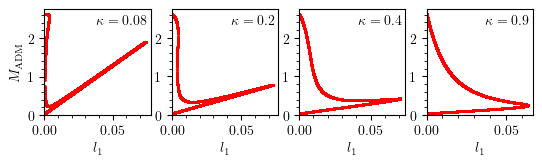

In [ ]:
# plot the results

fig_width      = pu.textwidth * pu.cm_to_inch
n_panels       = len(all_data)
panel_w        = fig_width / n_panels

fig, axes = plt.subplots(
    1, n_panels,
    figsize=(fig_width, panel_w),
    constrained_layout=False,            # turn off constrained_layout
    gridspec_kw={'wspace': 0.2}         # <-- shrink width spacing
)


for ax, entry in zip(axes, all_data):
    kappa      = entry['kappa']
    l1_arr = entry['l1_vals']
    m_arr  = entry['m_adm']

    ax.scatter(l1_arr, m_arr, s=1, color="red", rasterized=True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.minorticks_on()
    ax.set_xlabel(r"$l_1$")
    if ax is axes[0]:
        ax.set_ylabel(r"$M_{\mathrm{ADM}}$")

    ax.set_box_aspect(1)

    ax.text(
        0.97, 0.95,
        rf"$\kappa={kappa:.1g}$",
        transform=ax.transAxes,
        ha="right", va="top"
    )

plt.savefig("img/2dirac_m_vs_l1_varied_kappa.pdf", bbox_inches="tight", dpi=300)


In [ ]:
# calculate solution curve M_ADM vs l2 for different kappa values, with fixed l1

l1 = 0.001
l2 = 0.02 # relative length scale
kappa_values = [0.005, 0.05, 0.4, 0.9]

grain = 0.005
alpha_max = 5.0
alpha_steps = int(round(alpha_max / grain)) + 1
alpha_values = np.linspace(1e-7, alpha_max, alpha_steps)

all_data = []
for kappa in kappa_values:
    l2_list = []
    m_list  = []

    for alpha in alpha_values:
        current_l1 = l1
        current_l2 = alpha * l2
        current_kappa = kappa
        if alpha == 0.0:
            m_results = [0.0] if abs(kappa) > 1e-9 else []
        else:
            m_results = get_roots(current_l1, current_l2, current_kappa)

        for m in m_results:
            l2_list.append(current_l2)
            m_list.append(m)

    all_data.append({
        'kappa': current_kappa,
        'l2_vals': np.array(l2_list),
        'm_adm':   np.array(m_list)
    })

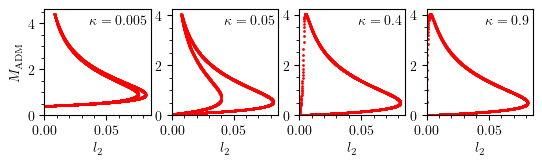

In [ ]:
# plot the results

fig_width      = pu.textwidth * pu.cm_to_inch
n_panels       = len(all_data)
panel_w        = fig_width / n_panels

fig, axes = plt.subplots(
    1, n_panels,
    figsize=(fig_width, panel_w),
    constrained_layout=False, 
    gridspec_kw={'wspace': 0.2} 
)


for ax, entry in zip(axes, all_data):
    kappa      = entry['kappa']
    l2_arr = entry['l2_vals']
    m_arr  = entry['m_adm']

    ax.scatter(l2_arr, m_arr, s=1, color="red", rasterized=True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.minorticks_on()
    ax.set_xlabel(r"$l_2$")
    if ax is axes[0]:
        ax.set_ylabel(r"$M_{\mathrm{ADM}}$")

    ax.set_box_aspect(1)

    ax.text(
        0.97, 0.95,
        rf"$\kappa={kappa:.1g}$",
        transform=ax.transAxes,
        ha="right", va="top"
    )

plt.savefig("img/2dirac_m_vs_l2_varied_kappa.pdf", bbox_inches="tight", dpi=300)


In [ ]:
# calculate solution curve M_ADM vs kappa for different values of l2, with fixed l1

l1 = 1e-7
l2_vals = [1e-3, 5e-6, 6e-7, 1e-7]
kappa_values = np.linspace(0, 1, 1000)


all_data = []
for l2 in l2_vals:
    m_list  = []
    kappa_list = []
    
    for kappa in kappa_values:
        m_results = get_roots(l1, l2, kappa)
        for m in m_results:
            m_list.append(m)
            kappa_list.append(kappa)

    all_data.append({
        'l2': l2,
        'kappa_vals': np.array(kappa_list),
        'm_adm': np.array(m_list)
    })       

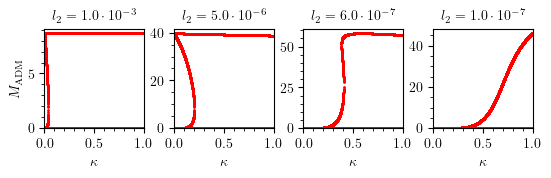

In [ ]:
#plot the results

fig_width      = pu.textwidth * pu.cm_to_inch
n_panels       = len(all_data)
panel_w        = fig_width / n_panels

fig, axes = plt.subplots(
    1, n_panels,
    figsize=(fig_width, panel_w),
    constrained_layout=False, 
    gridspec_kw={'wspace': 0.3} 
)

for ax, entry in zip(axes, all_data):
    l2         = entry['l2']
    kappa_arr  = entry['kappa_vals']
    m_arr      = entry['m_adm']

    ax.scatter(kappa_arr, m_arr, s=1, color="red", rasterized=True)
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0)
    ax.minorticks_on()
    ax.set_xlabel(r"$\kappa$")
    
    if ax is axes[0]:
        ax.set_ylabel(r"$M_{\mathrm{ADM}}$")

    ax.set_box_aspect(1)

    exponent = int(np.floor(np.log10(l2)))  
    mantissa = l2 / 10**exponent

 
    ax.set_title(
        rf"$l_2={mantissa:.1f}\cdot 10^{{{exponent}}}$",
        fontsize=10
    )


plt.savefig("img/2dirac_m_vs_kappa_varied_l2.pdf", bbox_inches="tight", dpi=300)